In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
import RiskSLIM as slim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_M2_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test
no stored variable summary_M2_KY_interpret


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [3]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_M_two_year'].values

In [4]:
#### CART
depth = [7,8,9]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [20]
depth = [2]
learning_rate = [0.3]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

model_id, score_thresholds 0 {'rank_abs': [849]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [949]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [1175]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [1218]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [1073]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [1099]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [1190]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [1156]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [1105]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [1061]}
get_disparity_predefined_group()


In [5]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.7030375736229602, 0.011760264698188671)

In [6]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.7125336080636797, 0.004566020388930325)

## Lasso Stumps

In [7]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_M_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_M_two_year'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_M_two_year'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [8]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.007, 0.005, 0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [14273]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14979]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14385]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13943]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14745]}
get_disparity_predefined_group()


In [9]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}],
 0.709835340651588,
 0.0007328280253636521)

##### Best Stump Model

In [14]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.003, columns=cols, seed=816)

##### Prediction Table

In [15]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| sex                               | 8.8            |
| age_at_current_charge<=38         | 5.1            |
| age_at_current_charge<=43         | 3.8            |
| age_at_current_charge<=46         | 5.3            |
| p_arrest>=1                       | -30.8          |
| p_arrest>=2                       | 53.2           |
| p_arrest>=3                       | 32.2           |
| p_arrest>=4                       | 20.1           |
| p_arrest>=5                       | 18.3           |
| p_arrest>=6                       | 12.7           |
| p_arrest>=7                       | 5.2            |
| p_charges>=1                      | -37.3          |
| p_violence>=1                     | 15.4           |
| p_felony>=2                       | -6.4           |
| p_misdemeanor>=1                  | 6.2            |
| p_misdem

In [16]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [13512]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13358]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13515]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13351]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13296]}
get_disparity_predefined_group()


In [17]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.003}, {'C': 0.003}, {'C': 0.003}, {'C': 0.003}, {'C': 0.003}],
 0.7062530901638538,
 0.00044542381557681753)

##### Stumps Visualizations

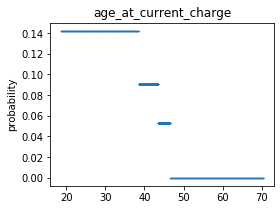

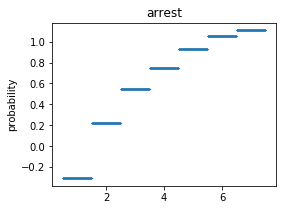

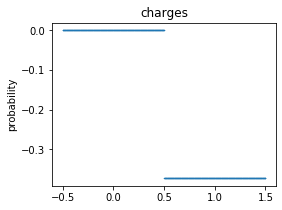

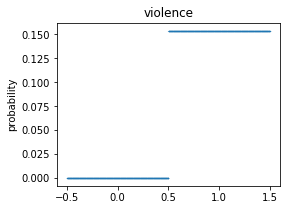

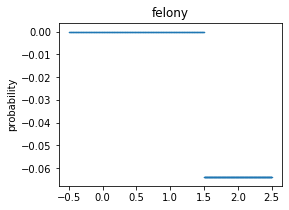

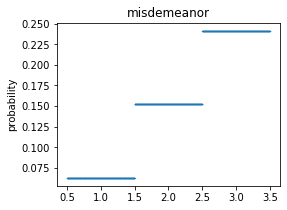

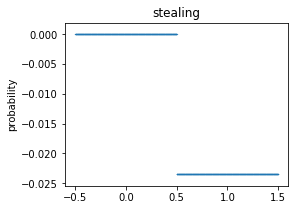

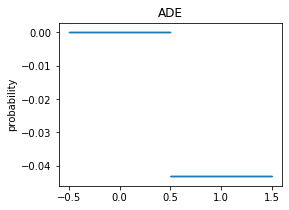

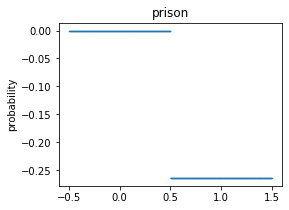

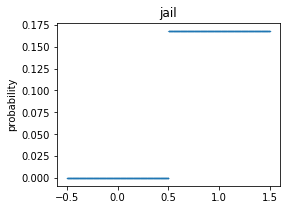

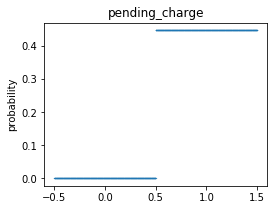

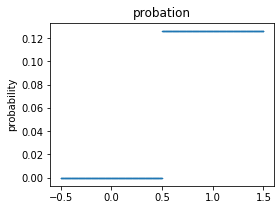

In [18]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

### Arnold PSA

In [19]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold_raw = data['nca_risk_score_raw'].values
X_arnold_calc = data['nca_calc'].values
Y_arnold = data['recid_M_two_year'].values

In [20]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_auc.append(roc_auc_score(y_test, y_pred_raw))
    calc_auc.append(roc_auc_score(y_test, y_pred_calc))
    i+=1 

## RiskSLIM

In [34]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_M_two_year'].values
cols = x.columns[3:]

In [39]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.003, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

24

In [36]:
### Subset features
if 'sex' in selected_features:
    selected_features = ['recid_M_two_year', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_M_two_year', 'person_id', 'screening_date', 'race', 'sex'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [37]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='recid_M2', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-5, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/11/19 @ 11:14 AM | 621 rows in lookup table
09/11/19 @ 11:14 AM | ------------------------------------------------------------
09/11/19 @ 11:14 AM | runnning initialization procedure
09/11/19 @ 11:14 AM | ------------------------------------------------------------
09/11/19 @ 11:14 AM | CPA produced 2 cuts
09/11/19 @ 11:14 AM | running naive rounding on 132 solutions
09/11/19 @ 11:14 AM | best objective value: 0.4431
09/11/19 @ 11:14 AM | rounding produced 2 integer solutions
09/11/19 @ 11:14 AM | best objective value is 0.4599
09/11/19 @ 11:14 AM | running sequential rounding on 132 solutions
09/11/19 @ 11:14 AM | best objective value: 0.4431
09/11/19 @ 11:14 AM | sequential rounding produced 1 integer solutions
09/11/19 @ 11:14 AM | best objective value: 0.4567
09/11/19 @ 11:14 AM | polishing 3 solutions
09/11/19 @ 11:14 AM | best objective value: 0.4567
09/11/19 @ 11:14 AM | polishing produced 3 integer solutions
09/11/19

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:14 AM | adding 131 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.4567.
Tried aggregator 1 time.
Reduced MIP has 15 rows, 30 columns, and 55 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:14 AM | adding 129 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.4591.
Tried aggregator 1 time.
Reduced MIP has 15 rows, 30 columns, and 55 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:15 AM | adding 122 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.4548.
Tried aggregator 1 time.
Reduced MIP has 15 rows, 30 columns, and 55 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:15 AM | adding 135 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.4558.
Tried aggregator 1 time.
Reduced MIP has 15 rows, 30 columns, and 55 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:15 AM | adding 129 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.4549.
Tried aggregator 1 time.
Reduced MIP has 15 rows, 30 columns, and 55 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

In [38]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.6660618542875627, 0.6660784306230215)

### Results

In [27]:
#### save results
summary_M2_KY_interpret = {"CART": cart_summary,
                                   "EBM": ebm_summary, 
                                   'Lasso Stumps': stump_summary, 
                                   'RiskSLIM': riskslim_summary, 
                                   'Arnold PSA Raw': raw_auc, 
                                   'Arnold PSA': calc_auc}
%store summary_M2_KY_interpret

Stored 'summary_M2_KY_interpret' (dict)


In [28]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3)]]
results

[['CART', 0.7030375736229602, 0.011760264698188671],
 ['EBM', 0.7125336080636797, 0.004566020388930325],
 ['Lasso Stumps', 0.7062530901638538, 0.00044542381557681753],
 ['RiskSLIM', 0.6660784306230215],
 ['Arnold PSA Raw', 0.687],
 ['Arnold PSA', 0.678]]

In [32]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [33]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Two Year/"
results = [["Misdemeanor", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(raw_auc), 3)) + " (" + np.str(round(np.std(raw_auc),3)) + ")", 
            np.str(round(np.mean(calc_auc), 3)) + " (" + np.str(round(np.std(calc_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)